# Using alternative topographical datasets with OGGM

Here we compare inversion using the SRTM DEM and our own LiDAR DEMs 

Part I: SRTM DEM inversion

Part II: LiDAR DEM inversion

Part III: Compare GPR observations to inversion ice thicknesses

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, graphics

In [2]:
products_dir = '/home/pelto/Desktop/ice_thick/alt_dem/' 
num = 2
rgi_list = ['RGI60-02.07780', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.04264', 'RGI60-02.03688', 'RGI60-02.00147', 'RGI60-02.03411']
glacier = ['zillmer', 'haig', 'conrad', 'nordic', 'illecillewaet', 'kokanee', 'W.Washmawapta']

# Part I: SRTM DEM inversion



In [3]:
WORKING_DIR = utils.gettempdir(glacier[num] + '_srtm_dem') # Let's make a working directory for this DEM 
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR
# cfg.PARAMS['dl_verify'] = False ##shouldn't need right???

2019-10-03 09:43:33: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [4]:
dx = 50
smooth = 51.

cfg.PARAMS['border'] = 10
cfg.PARAMS['smooth_window'] = smooth

In [5]:
cfg.PARAMS['grid_dx_method'] = 'fixed'
cfg.PARAMS['fixed_dx'] = dx
if glacier[num] == 'nordic' or 'W.Washmawapta':
    cfg.PARAMS['use_intersects'] = False

In [6]:
rgidf = utils.get_rgi_glacier_entities([rgi_list[num]])
gdirs = workflow.init_glacier_regions(rgidf)
workflow.gis_prepro_tasks(gdirs) #shortcut function: run all flowline preprocessing tasks.
workflow.climate_tasks(gdirs) #shortcut function: run all climate related tasks
workflow.inversion_tasks(gdirs) #shortcut function: run all ice thickness inversion tasks
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
gdir = gdirs[0]
tasks.init_present_time_glacier(gdir) # Merges data from preprocessing tasks. First task after inversion! This 
##updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

2019-10-03 09:43:34: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-10-03 09:43:34: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-10-03 09:43:34: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-10-03 09:43:34: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-10-03 09:43:34: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-10-03 09:43:35: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-10-03 09:43:35: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-10-03 09:43:35: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-10-03 09:43:37: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anacon

In [7]:
ds_srtm = xr.open_dataset(gdir.get_filepath('gridded_data'))
ds_srtm

<xarray.Dataset>
Dimensions:                (x: 137, y: 163)
Coordinates:
  * x                      (x) float32 -3938.1206 -3888.1206 ... 2861.8794
  * y                      (y) float32 5631963.5 5631913.5 ... 5623863.5
Data variables:
    topo                   (y, x) float32 ...
    topo_smoothed          (y, x) float32 ...
    glacier_mask           (y, x) int8 ...
    glacier_ext            (y, x) int8 ...
    glacier_ext_erosion    (y, x) int8 ...
    ice_divides            (y, x) int8 ...
    slope                  (y, x) float32 ...
    aspect                 (y, x) float32 ...
    slope_factor           (y, x) float32 ...
    dis_from_border        (y, x) float32 ...
    distributed_thickness  (y, x) float32 ...
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    proj_srs:       +proj=tmerc +lat_0=0.0 +lon_0=-116.93 +k=0.9996 +x_0=0 +y...
    max_h_dem:      3237.0
    min_h_dem:      1259.0
    max_h_glacier:  3214.0
    min_h_glacier:  184

In [8]:
mfl=gdir.read_pickle('model_flowlines')
thickness_srtm = mfl[-1].surface_h - mfl[-1].bed_h
thickness_srtm.mean()

123.61806204939734

In [9]:
srtm_thick = thickness_srtm[thickness_srtm>0].mean()
srtm_thick

131.06493325719234

You can access the (reprojected and interpolated) DEM file in the working directory:

In [10]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-02.02171
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 16.898 km2
  Lon, Lat: (-116.93, 50.8069)
  Grid (nx, ny): (137, 163)
  Grid (dx, dy): (50.0, -50.0)

In [11]:
dem_path = gdir.get_filepath('dem')
dem_path

'/tmp/OGGM/conrad_srtm_dem/per_glacier/RGI60-02/RGI60-02.02/RGI60-02.02171/dem.tif'

It is a geotiff file. [Xarray](http://xarray.pydata.org) can open them thanks to [rasterio](https://rasterio.readthedocs.io):

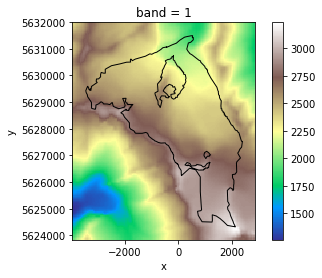

In [12]:
da1 = dem_path
da = xr.open_rasterio(dem_path)
f, ax = plt.subplots()
da.plot(cmap='terrain', ax=ax);
# Add the outlines
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

The source of the DEM is documented in the directory itself:

In [13]:
with open(gdir.get_filepath('dem_source'), 'r') as f:
    print(f.read())

SRTM V4

Original resolution: 3 arcsec (~90m)

# Data Citation

We kindly ask  any users to  cite this data  in any published  material
produced using this data, and if possible link web pages to the CIAT-CSI
SRTM website (http://srtm.csi.cgiar.org).

Citations should be made as follows:

Jarvis A., H.I. Reuter, A.  Nelson, E. Guevara, 2008, Hole-filled seamless SRTM
data V4, International  Centre for Tropical  Agriculture (CIAT), available
from http://srtm.csi.cgiar.org,


# Data files

srtm_13_02.tif



In [14]:
# graphics.plot_inversion(gdir, figsize=(8, 7)) #vmax=400
# #plt.savefig('conrad_thick_10m_user2014.png')

In [15]:
# graphics.plot_distributed_thickness(gdir, figsize=(8, 7))

In [16]:
utils.compile_glacier_statistics(gdir, inversion_only=True)

2019-10-03 09:43:40: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,inv_thickness_m,vas_volume_km3,vas_thickness_m,dem_source,n_orig_centerlines,perc_invalid_flowline
rgi_id,,,,,,,,,,,,,,,,
RGI60-02.02171,02,02-03,,-116.93,50.8069,16.898,Glacier,Land-terminating,Glacier or ice cap,1.674127,99.072505,1.658641,98.156069,SRTM,5,0.0


## Part II: LiDAR DEM inversion

Let's import out LiDAR DEM of choice:

In [17]:
cust_path = '/home/pelto/Desktop/lidar_cbt_analysis/' + glacier[num]
dem = ['/160914_zillmer_dem2.tif', '/20150912_haig_dem_master_clip_SB.tif', '/20160912_conrad_dem1_clip_slave.tif', 
'/20170927_nordic_dem1_clip_slave.tif', '/170917_illecillewaet_dem1_clip_slave.tif', '/20160913_kokanee_dem1_clip_slave.tif']
custom_dem_path = cust_path + dem[num]
custom_dem_path

'/home/pelto/Desktop/lidar_cbt_analysis/conrad/20160912_conrad_dem1_clip_slave.tif'

We tell OGGM to use it by changing the entry in the RGI table and by giving the path to the file:

In [18]:
WORKING_DIR2 = utils.gettempdir(glacier[num] + '_lidar_dem') # Let's make a working directory for this DEM 
utils.mkdir(WORKING_DIR2, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR2

2019-10-03 09:43:40: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [19]:
cfg.PATHS['dem_file'] = custom_dem_path
rgidf['DEM_SOURCE'] = 'USER'

In [20]:
cfg.PARAMS['border'] = 10
cfg.PARAMS['smooth_window'] = smooth
cfg.PARAMS['grid_dx_method'] = 'fixed'
cfg.PARAMS['fixed_dx'] = dx
if glacier[num] == 'nordic':
    cfg.PARAMS['use_intersects'] = False
gdirs = workflow.init_glacier_regions(rgidf)

2019-10-03 09:43:40: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-10-03 09:43:40: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:516: RuntimeWarning: invalid value encountered in less_equal
  dem[dem <= min_z] = np.NaN
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Now the user provided DEM is used:

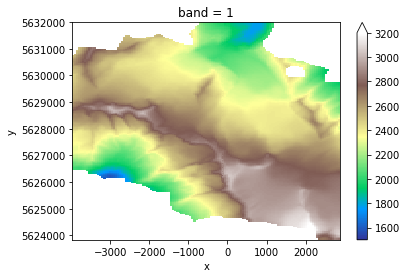

In [21]:
gdir = gdirs[0]
da_user1 = gdir.get_filepath('dem')
da_user = xr.open_rasterio(gdir.get_filepath('dem'))
da_user.plot(cmap='terrain', vmax=3200, vmin=1500);
# gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

In [22]:
workflow.gis_prepro_tasks(gdirs) #shortcut function: run all flowline preprocessing tasks.
workflow.climate_tasks(gdirs) #shortcut function: run all climate related tasks
workflow.inversion_tasks(gdirs) #shortcut function: run all ice thickness inversion tasks
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
tasks.init_present_time_glacier(gdir) # Merges data from preprocessing tasks. 

2019-10-03 09:43:42: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-10-03 09:43:42: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-10-03 09:43:42: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-10-03 09:43:43: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-10-03 09:43:43: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-10-03 09:43:43: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-10-03 09:43:45: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
2019-10-03 09:43:45: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-10-03 09:43:45: oggm.workflow: Execute entity task catchment_width_correction on 1 glaciers
2019-10-03 09:43:45: oggm.workflow: Execute entity task process_cru_data on 1 glaciers
2019-10-03 09:43:46: oggm.workflow: Execute entity task local_t_star on 1 glaciers
2019-1

In [23]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-02.02171
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 16.898 km2
  Lon, Lat: (-116.93, 50.8069)
  Grid (nx, ny): (137, 163)
  Grid (dx, dy): (50.0, -50.0)

In [24]:
da1

'/tmp/OGGM/conrad_srtm_dem/per_glacier/RGI60-02/RGI60-02.02/RGI60-02.02171/dem.tif'

In [25]:
da_user1

'/tmp/OGGM/conrad_lidar_dem/per_glacier/RGI60-02/RGI60-02.02/RGI60-02.02171/dem.tif'

In [26]:
import os
from osgeo import gdal
srtm_file = products_dir + glacier[num] + '_SRTM_diff_30m.tif'
os.system('gdal_calc.py ' + '-A ' + da1 + ' -B ' + da_user1 + ' --outfile=' + products_dir + glacier[num] + '_SRTM_diff_30m.tif ' + '--calc="B-A"' )

256

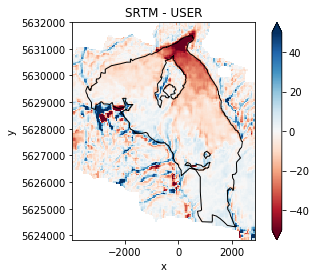

In [27]:
#some are failing here for whatever reason
f, ax = plt.subplots()
diff = da_user - da  #print(type(diff))
(diff).plot(ax=ax, vmax=50, cmap='RdBu');
plt.title('SRTM - USER');
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

In [28]:
fpath = gdir.get_filepath('gridded_data')
print(fpath)

/tmp/OGGM/conrad_lidar_dem/per_glacier/RGI60-02/RGI60-02.02/RGI60-02.02171/gridded_data.nc


In [29]:
ds_alt = xr.open_dataset(gdir.get_filepath('gridded_data'))
ds_alt

<xarray.Dataset>
Dimensions:                (x: 137, y: 163)
Coordinates:
  * x                      (x) float32 -3938.1206 -3888.1206 ... 2861.8794
  * y                      (y) float32 5631963.5 5631913.5 ... 5623863.5
Data variables:
    topo                   (y, x) float32 ...
    topo_smoothed          (y, x) float32 ...
    glacier_mask           (y, x) int8 ...
    glacier_ext            (y, x) int8 ...
    glacier_ext_erosion    (y, x) int8 ...
    ice_divides            (y, x) int8 ...
    slope                  (y, x) float32 ...
    aspect                 (y, x) float32 ...
    slope_factor           (y, x) float32 ...
    dis_from_border        (y, x) float32 ...
    distributed_thickness  (y, x) float32 ...
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    proj_srs:       +proj=tmerc +lat_0=0.0 +lon_0=-116.93 +k=0.9996 +x_0=0 +y...
    max_h_dem:      3259.5938
    min_h_dem:      1589.3461
    max_h_glacier:  3223.9326
    min_h_glac

In [30]:
mfl=gdir.read_pickle('model_flowlines')
thickness_alt = mfl[-1].surface_h - mfl[-1].bed_h
thickness_alt.mean()

129.75223198978318

In [31]:
alt_thick = thickness_alt[thickness_alt>0].mean()
print('SRTM raw ice thickness (m):', srtm_thick)
print('LiDAR ice thickness (m):', alt_thick)
# print('SRTM corr ice thickness (m):', )

SRTM raw ice thickness (m): 131.06493325719234
LiDAR ice thickness (m): 139.24629774513318


In [32]:
#define glacier mask
with utils.ncDataset(fpath) as nc:
    topo = nc.variables['topo'][:]
    mask_ext = nc.variables['glacier_ext'][:]
    mask_glacier = nc.variables['glacier_mask'][:]
    mask_rock = nc.variables['glacier_mask'][:]

In [33]:
srtm_file

'/home/pelto/Desktop/ice_thick/alt_dem/conrad_SRTM_diff_30m.tif'

In [34]:
# #getting error because glacier_mask is not same dimensions as dems

# srtm = gdal.Open(srtm_file, gdal.GA_ReadOnly)
# band = srtm.GetRasterBand(1)
# dh_dt = band.ReadAsArray()
# SRTM_glac = dh_dt[mask_glacier == 1] #dh_dt[msk == 1]
# SRTM_glac[SRTM_glac > 20] = 0
# SRTM_rock = dh_dt[mask_glacier == 0]
# SRTM_rock[SRTM_rock > 20] = 0
# SRTM_rock[SRTM_rock < -20] = 0

In [35]:
# std = np.nanstd(SRTM_glac)
# SRTM_diff = np.nanmean(SRTM_glac)
# print(SRTM_diff, ' +/- ', std)
# std2 = np.nanstd(SRTM_rock)
# rock_diff = np.nanmean(SRTM_rock)
# print(rock_diff, ' +/- ', std2)
# # print(len(SRTM_glac))

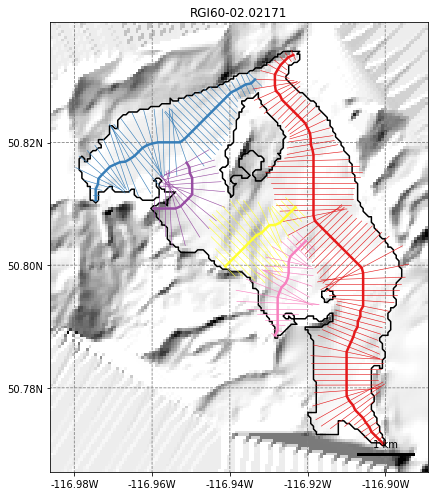

In [36]:
graphics.plot_catchment_width(gdir, corrected=True, figsize=(8, 7))
# fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')

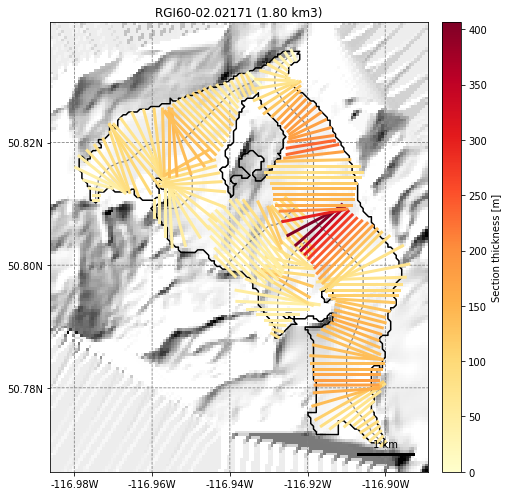

In [37]:
graphics.plot_inversion(gdir, figsize=(8, 7))
#plt.savefig('conrad_thick_10m_user2014.png')

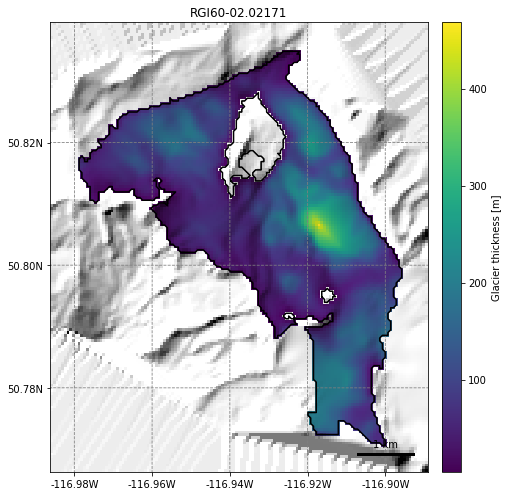

In [38]:
graphics.plot_distributed_thickness(gdir, figsize=(8, 7))

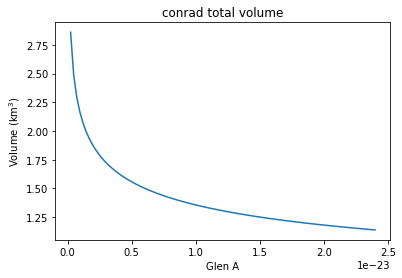

In [39]:
a_factor = np.linspace(0.1, 10., 100) * cfg.PARAMS['inversion_glen_a']
volume = []
for f in a_factor:
    v, _ = tasks.mass_conservation_inversion(gdir, glen_a=f, write=False)
    volume.append(v * 1e-9)
plt.plot(a_factor, volume); plt.title(glacier[num] + ' total volume');
plt.ylabel('Volume (km$^3$)'); plt.xlabel('Glen A'); 

In [40]:
utils.compile_glacier_statistics(gdir, inversion_only=True)

2019-10-03 09:43:49: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,inv_thickness_m,vas_volume_km3,vas_thickness_m,dem_source,dem_needed_interpolation,dem_invalid_perc,dem_needed_extrapolation,dem_extrapol_perc,n_orig_centerlines,perc_invalid_flowline
rgi_id,,,,,,,,,,,,,,,,,,,,
RGI60-02.02171,02,02-03,,-116.93,50.8069,16.898,Glacier,Land-terminating,Glacier or ice cap,1.804908,106.811907,1.658641,98.156069,USER,True,0.25131,True,0.180153,5,0.0


In [41]:
# utils.compile_glacier_statistics(gdir, inversion_only=False)

In [42]:
import pandas as pd
df = pd.read_csv(os.path.join(cfg.PATHS['working_dir'], 'glacier_statistics.csv'), index_col=0)
df

,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,inv_thickness_m,vas_volume_km3,vas_thickness_m,dem_source,dem_needed_interpolation,dem_invalid_perc,dem_needed_extrapolation,dem_extrapol_perc,n_orig_centerlines,perc_invalid_flowline
rgi_id,,,,,,,,,,,,,,,,,,,,
RGI60-02.02171,2,02-03,NaN,-116.93,50.8069,16.898,Glacier,Land-terminating,Glacier or ice cap,1.804908,106.811907,1.658641,98.156069,USER,True,0.25131,True,0.180153,5,0.0


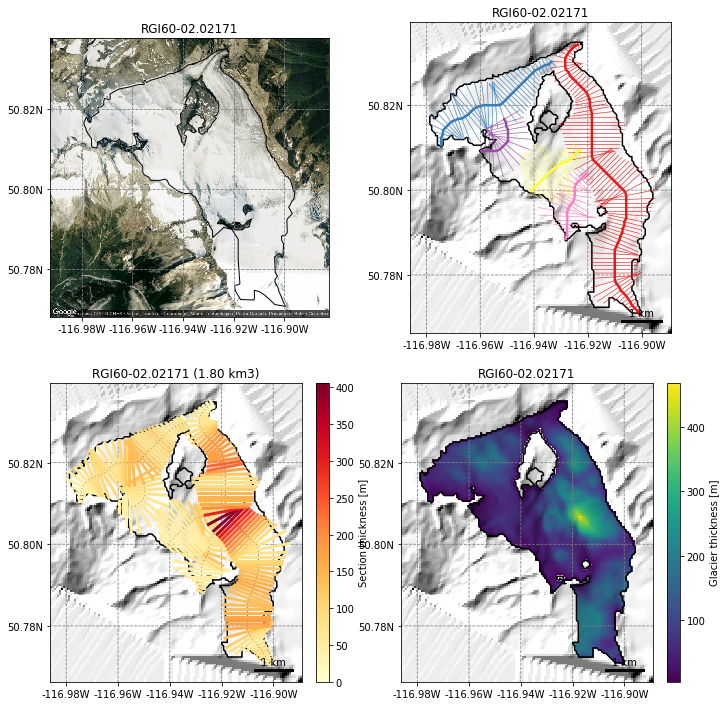

In [43]:
# # row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10)) #sharex='col', sharey='row', sharex=True, sharey=True,
graphics.plot_catchment_width(gdir, corrected=True, ax=ax2)
graphics.plot_googlemap(gdir, ax=ax1)
graphics.plot_distributed_thickness(gdir, ax=ax4)
graphics.plot_inversion(gdir, ax=ax3) #vmax=400
plt.tight_layout()
plt.savefig(products_dir + glacier[num] + '_four_panel_30m.png')


# Part III: Compare GPR observations to inversion ice thicknesses

Open GPR Data, and compare to OGGM model output:

In [44]:
import salem
data_path = '/home/pelto/GIS/GPR/Data/'
shapefile = ['zillmer_GPR_All_final_WGS84.shp', 'Haig/Haig_gpr_all_WGS84.shp', 'conrad_GPR_ALL_final_WGS84.shp', 
              '2016/Nordic_2016_GPR_final_WGS84.shp', '2018/illec_may18_final_WGS84_clipped.shp',  
             '2017/Kokanee_17_final_WGS84.shp', 'west_wash_data.shp']

df = salem.read_shapefile(data_path + shapefile[num])
    
coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# df['lon'] = df[4]
# df['lat'] = df[5]
df = df[['lon', 'lat', 'depth']]

In [45]:
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

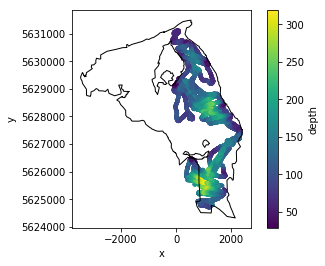

In [46]:
geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
df.plot.scatter(x='x', y='y', c='depth', cmap='viridis', s=10, ax=ax);
geom.plot(ax=ax, facecolor='none', edgecolor='k');

In [47]:
#The measurement points of this dataset are very frequent and close to each other. There are plenty of them:
len(df)

13769

In [48]:
##'gridded_data' output is limited if we are not using preprocessed directories
## is there a way to get these missing data variables?

vns = ['topo',
       'slope',
       'slope_factor',  
       'aspect',
       'dis_from_border',
       'distributed_thickness',
#        'catchment_area',
#        'lin_mb_above_z',
#        'lin_mb_above_z_on_catch',
#        'oggm_mb_above_z',
#        'oggm_mb_above_z_on_catch',
       ]



In [54]:
print(ds_alt['distributed_thickness'].mean())
print(ds_srtm['distributed_thickness'].mean())

<xarray.DataArray 'distributed_thickness' ()>
array(104.34499, dtype=float32)
<xarray.DataArray 'distributed_thickness' ()>
array(96.78435, dtype=float32)


In [55]:
ds_srtm['distributed_thickness_corr'] = ds_srtm['distributed_thickness'] + np.squeeze(diff.values)
dist_thick_srtm_corr = ds_srtm['distributed_thickness_corr']

# here we compare thickness over the entire glacier

In [56]:
# ds_alt['distributed_thickness'][ds_alt['distributed_thickness'] == 0] = np.nan
# dist_thick_srtm_corr[dist_thick_srtm_corr == 0] = np.nan
# ds_srtm['distributed_thickness'][ds_srtm['distributed_thickness'] == 0] = np.nan

In [57]:
dist_thick_srtm_corr = ds_srtm['distributed_thickness_corr'] * ds_srtm['glacier_mask']
# dist_thick_mean = dist_thick['glacier_mask' == 1] #[mask_glacier == 1]
print('whole glacier lidar_thick', ds_alt['distributed_thickness'].mean())
print('whole glacier srtm_thick raw:', np.round(np.mean(ds_srtm['distributed_thickness']),2))
print('whole glacier srtm_thick corr:', np.round(np.mean(dist_thick_srtm_corr),2))

whole glacier lidar_thick <xarray.DataArray 'distributed_thickness' ()>
array(104.34499, dtype=float32)
whole glacier srtm_thick raw: <xarray.DataArray 'distributed_thickness' ()>
array(96.78, dtype=float32)
whole glacier srtm_thick corr: <xarray.DataArray ()>
array(90.85, dtype=float32)


### Aggregate GPR measurements per grid point

There are so many points that much of the information obtained by OGGM is interpolated. A way to deal with this is to aggregate all the measurement points per grid point and average them. Let's do this: 

In [59]:
## for alt dem
df_agg = df[['lon', 'lat', 'depth']].copy()
ii, jj = gdir.grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# We trick by creating an index of similar i's and j's
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

##for srtm
df_agg2 = df[['lon', 'lat', 'depth']].copy()
ii, jj = gdir.grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg2['i'] = ii
df_agg2['j'] = jj
# We trick by creating an index of similar i's and j's
df_agg2['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg2 = df_agg2.groupby('ij').mean()

In [60]:
len(df_agg)

1296

We now have 9 times less points, but the main features of the data remain unchanged:

In [61]:
# Select
for vn in vns:
    df_agg[vn] = ds_alt[vn].isel(x=('z', df_agg.i), y=('z', df_agg.j))
    df_agg2[vn] = ds_srtm[vn].isel(x=('z', df_agg2.i), y=('z', df_agg2.j))

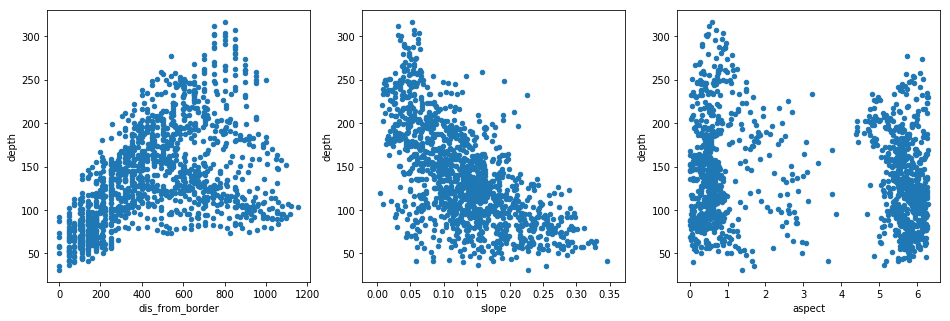

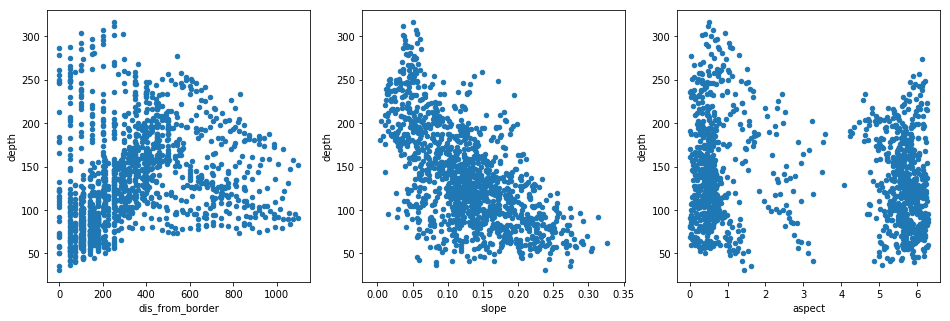

In [62]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df_agg.plot.scatter(x='dis_from_border', y='depth', ax=ax1);
df_agg.plot.scatter(x='slope', y='depth', ax=ax2);
df_agg.plot.scatter(x='aspect', y='depth', ax=ax3);

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df_agg2.plot.scatter(x='dis_from_border', y='depth', ax=ax1);
df_agg2.plot.scatter(x='slope', y='depth', ax=ax2);
df_agg2.plot.scatter(x='aspect', y='depth', ax=ax3);

## here we compare thickness at GPR locations

In [63]:
# ds = xr.open_dataset(gdir.get_filepath('gridded_data'))
df_agg2['srtm_thick_corr'] = ds_srtm.distributed_thickness_corr.isel(x=('z', df_agg2['i']), y=('z', df_agg2['j']))
df_agg['lidar_thick'] = ds_alt.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))
df_agg2['srtm_thick'] = ds_srtm.distributed_thickness.isel(x=('z', df_agg2['i']), y=('z', df_agg2['j']))

# print(len(df_agg['depth']), len(df_agg['oggm_thick']))
print('srtm thick corr:', round(np.mean(df_agg2['srtm_thick_corr']), 2), '+/-' , round(np.std(df_agg2['srtm_thick_corr']), 2))
print('srtm thick:', round(np.mean(df_agg2['srtm_thick']), 2), '+/-' , round(np.std(df_agg2['srtm_thick']), 2))
print('lidar_thick:', round(np.mean(df_agg['lidar_thick']), 2), '+/-' , round(np.std(df_agg['lidar_thick']), 2))
print('GPR thick:', round(np.mean(df_agg['depth']), 2), '+/-', round(np.std(df_agg['depth']), 2))

srtm thick corr: 152.3 +/- 72.2
srtm thick: 161.12 +/- 70.86
lidar_thick: 173.83 +/- 72.83
GPR thick: 139.6 +/- 56.33


In [64]:
utils.compile_glacier_statistics(gdir, inversion_only=True)

2019-10-03 09:44:51: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,inv_thickness_m,vas_volume_km3,vas_thickness_m,dem_source,dem_needed_interpolation,dem_invalid_perc,dem_needed_extrapolation,dem_extrapol_perc,n_orig_centerlines,perc_invalid_flowline
rgi_id,,,,,,,,,,,,,,,,,,,,
RGI60-02.02171,02,02-03,,-116.93,50.8069,16.898,Glacier,Land-terminating,Glacier or ice cap,1.804908,106.811907,1.658641,98.156069,USER,True,0.25131,True,0.180153,5,0.0


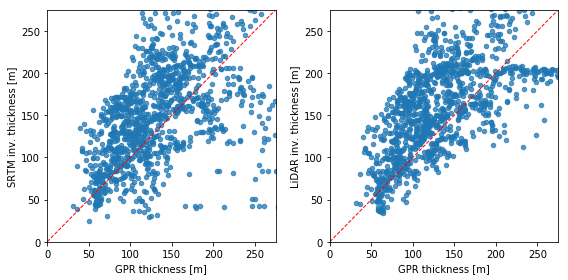

In [65]:
val = 275

f, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 4));
df_agg.plot.scatter(x='depth', y='lidar_thick', ax=ax2, alpha=0.75);
ax2.plot(np.arange(0, val), np.arange(0, val), 'r--', linewidth=1, zorder=1)
ax2.set_ylabel('LiDAR inv. thickness [m]')
ax2.set_xlabel('GPR thickness [m]')
ax2.set_xlim([0, val]);
ax2.set_ylim([0, val]);

df_agg2.plot.scatter(x='depth', y='srtm_thick', ax=ax, alpha=0.75);
ax.plot(np.arange(0, val), np.arange(0, val), 'r--', linewidth=1, zorder=1)
ax.set_ylabel('SRTM inv. thickness [m]')
ax.set_xlabel('GPR thickness [m]')
ax.set_xlim([0, val]);
ax.set_ylim([0, val]);
plt.tight_layout()
# ax2.text(10, 90, OGGM_thick, fontsize=15)

In [66]:
# cfg.BASENAMES['inversion_flowlines']
cfg.PARAMS['use_multiple_flowlines']

True

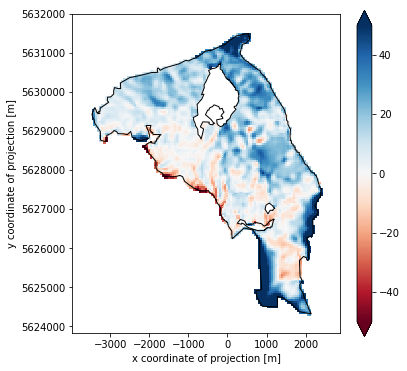

In [67]:
##plot OGGM thickness corrected for SRTM difference
f, ax = plt.subplots(figsize=(6,6))
(ds_alt.distributed_thickness - ds_srtm.distributed_thickness_corr).plot(ax=ax, cmap='RdBu', vmin =-50, vmax=50); #'RdBu'
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');
plt.savefig(products_dir + glacier[num] + '_DEMsource_diff_srtmcorr.png', dpi=600)
plt.show()